# User guide for regression data
First of all you need to have `numpy`, `pandas` and `matplotlib` installed to run this notebook with all examples. Secondly, the `plot_utils` code need to be on your PYTHONPATH, which can be performed in your terminal or programatically (as done here). The 'src' string in the code needs to be a valid path to the src-directory of the cloned git-repo for the code to run as expected.

In [1]:
# Make sure to add the code to your PYTHONPATH
import sys
sys.path.append('src')

Secondly we will import the packages required, both plotting/metrics and matplotlib for showing how to customize figures. For regression we also supply some utility convenience functions for loading and converting input matrices into the 3 dim tensor that is required when using the regression functions (following the standard of [nonconformist](https://github.com/donlnz/nonconformist)) where predictions are either 2D (a single significance level) of shape `(num_examples,2)` or 3D (for several significance levels) of shape `(num_examples,2,num_significance_levels)`.

In [2]:
from pharmbio.cp import metrics, plotting
import matplotlib.pyplot as plt # For customizations 
import numpy as np # Loading of data

# Data loading from CPSign
from pharmbio.cpsign import *

Now we load two different prediction outputs, the first was generated from nonconformist and saved as a pickled file, and the second one was generated through [CPSign](https://arosbio.com/cpsign/docs/latest/).

In [3]:
# Pickled data saved from numpy 
boston_preds = np.load('test/resources/boston_pred_out_3D_169_normalized.npy')
boston_labels = np.load('test/resources/boston_labels.npy')
boston_signs = np.arange(0.01,1,0.01) # from nonconformist
# CPSign generated prediction file
(y,preds,signs) = load_reg_predictions('test/resources/cpsign_reg_predictions.csv','y', sep=',')
print('boston_preds.shape: {}'.format(boston_preds.shape))
print('preds.shape: {}'.format(preds.shape))

# CPSign computed values
(cpsign_sign,cpsign_error_rates,cpsign_error_rates_sd,_) = load_calib_stats('test/resources/cpsign_reg_stats.csv', sep='\t')
(_, median_widths, mean_widths, median_widths_sd, mean_widths_sd) = load_reg_efficiency_stats('test/resources/cpsign_reg_stats.csv', sep='\t')

boston_preds.shape: (169, 2, 99)
preds.shape: (105, 2, 100)


In [4]:
cpsign_sign.shape

(19,)

The 'boston' predictions thus contains 169 examples, 2 values for the second dimension (lower and upper values of the prediction interval) and 99 significance levels. The 'preds' contain 105 examples and 100 significance levels.

## Plotting
Here we present the plots that can be generated through `Plot_utils`, then ones we feel are the most important ones for presenting Conformal Regression predictions. The regression API is slightly different compared to the classification one, requiring to manually call the metrics and give the result to the plotting functions instead of giving the p-values. Internally our package loads the 'Seaborn' package in case it is available, which will update the matplotlib default settings. The default settings is a grayish plotting area, where we instead prefere the theme 'ticks' without the top and right axes spines - thus we've added a wrapper function that sets the plotting settings (be aware that this will update your global settings!).

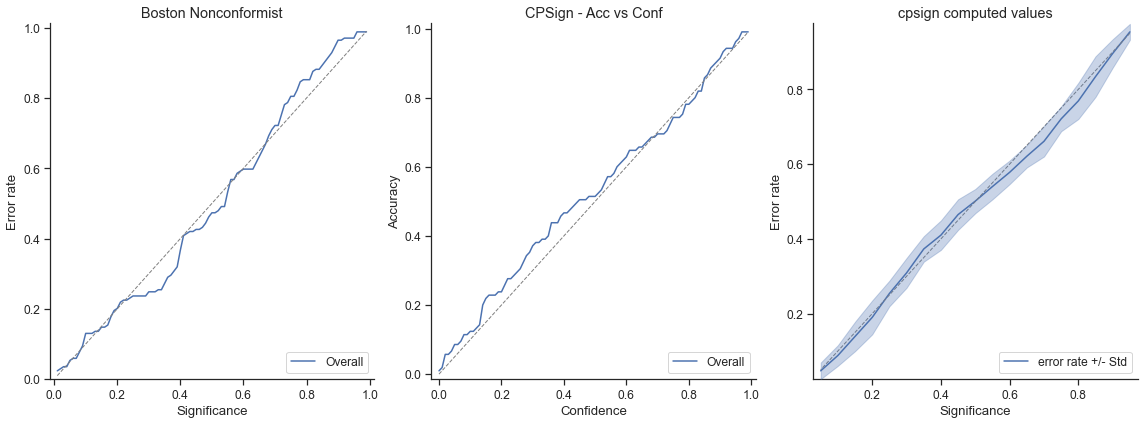

In [5]:
# Update global plott-settings + use 10% increased font size from the default
plotting.update_plot_settings(font_scale=1.1) 

# Calibration curve
fig, axes = plt.subplots(1,3,figsize=(16,6))
# Boston
error_rates = metrics.frac_error_reg(boston_labels,boston_preds)
plotting.plot_calibration(boston_signs,error_rates, ax=axes[0], title='Boston Nonconformist')
# CPSign - we can also flip the orientation from error-rate vs significance to accuracy vs confidence
error_rates_2 = metrics.frac_error_reg(y, preds)
plotting.plot_calibration(signs,error_rates_2, ax=axes[1],flip_x=True,flip_y=True)
axes[1].set_title('CPSign - Acc vs Conf',fontsize='x-large') # Or set using matplotlib axes instead
# CPSign precomputed stats
plotting.plot_calibration(cpsign_sign, cpsign_error_rates, cpsign_error_rates_sd,
                          ax=axes[2], title='cpsign computed values', labels='error rate +/- Std')
pass

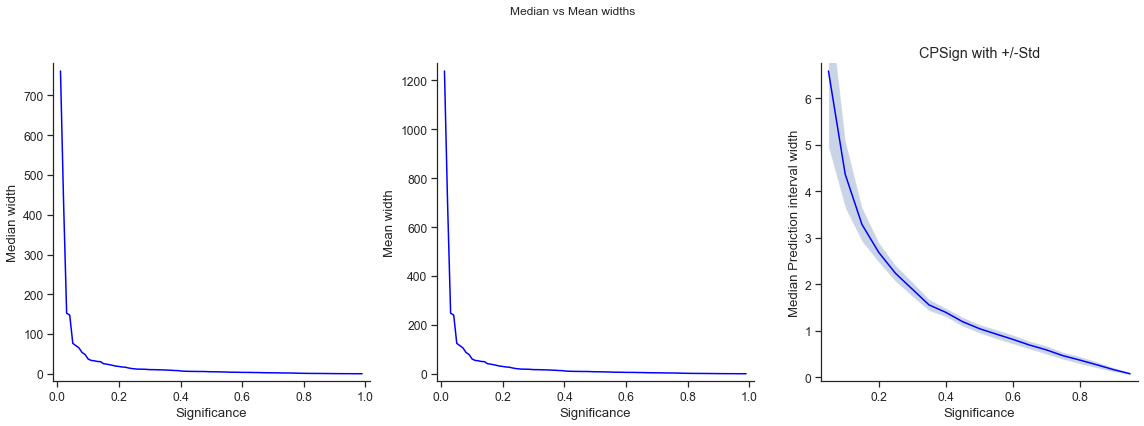

In [6]:
# Efficiency plot

fig, axes = plt.subplots(1,3,figsize=(16,6))

median_w = metrics.pred_width(boston_preds)
plotting.plot_pred_widths(boston_signs,median_w, ax=axes[0],y_label='Median width')
mean_w = metrics.pred_width(boston_preds,median=False)
plotting.plot_pred_widths(boston_signs,mean_w, ax=axes[1], y_label='Mean width')
plotting.plot_pred_widths(cpsign_sign, median_widths, median_widths_sd, title='CPSign with +/-Std', ax=axes[2])

fig.suptitle('Median vs Mean widths')
fig.tight_layout(rect=[0, 0, 1, 0.96])

Those plots are hard to see anything usefull from, so we plot them together instead and cap the smallest significance levels as they are too wide to be informative. 

In [7]:
# Utility function for finding the index in a list of significance values
def fetch_index(sign_vals, level):
    return np.where(abs(sign_vals-level)< 0.0001)[0][0]

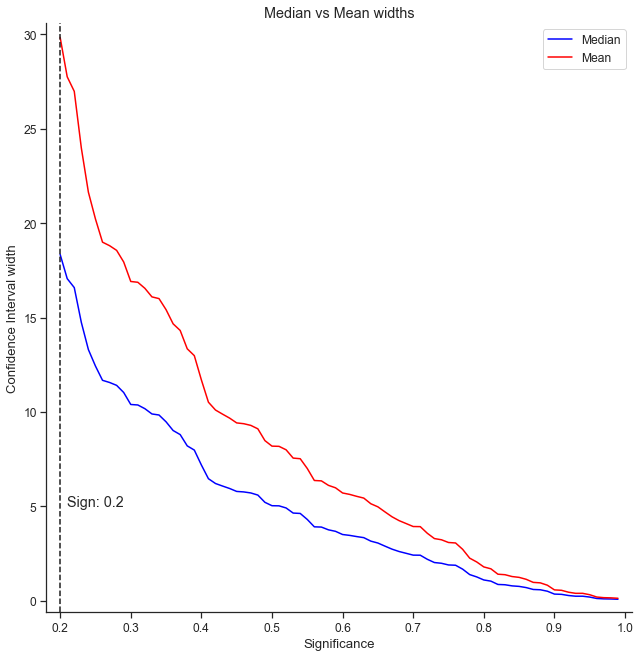

In [8]:
fig, ax = plt.subplots(1,figsize=(9,9))

significance = .2 # start to plot from

si = fetch_index(boston_signs,significance)
median_w = metrics.pred_width(boston_preds)
plotting.plot_pred_widths(boston_signs[si:],median_w[si:], ax=ax, y_label='Median')
mean_w = metrics.pred_width(boston_preds,median=False)
plotting.plot_pred_widths(boston_signs[si:],mean_w[si:], ax=ax, color='red', y_label='Mean')
ax.set_ylabel('Confidence Interval width')

ax.axvline(boston_signs[si],ls='--',color='k')
ax.text(boston_signs[si]+.01, 5, 'Sign: {}'.format(round(significance,2)),fontsize='x-large')
ax.legend()
ax.set_title('Median vs Mean widths',fontsize='x-large')
pass

## Plotting the prediction intervals
This plotting functionality requires a 2D input matrix for the predictions, i.e., we're only plotting the prediction intervals for a single significance level! There are quite a few parameters that can be tweaked, here showing the default  in the top one and the bottom one we're changing the marker for the incorrect and set some custom colors to add highlighting to the erronious intervals. 

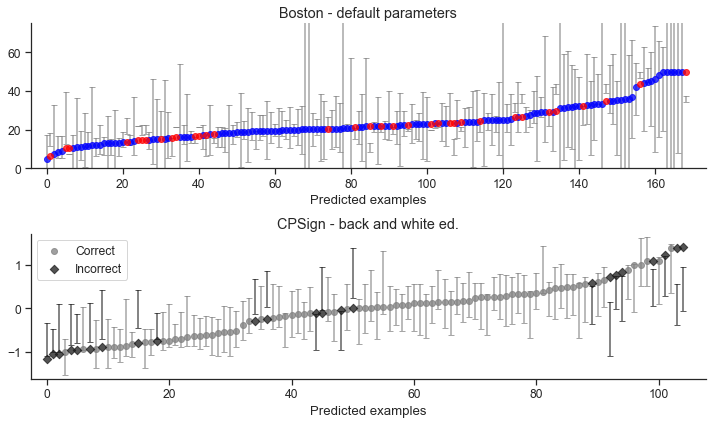

In [9]:
fig, axes = plt.subplots(2,1,figsize=(10,6))

sign_level = 0.2 # 80% confidence

# Boston
ind = fetch_index(boston_signs, sign_level)
plotting.plot_pred_intervals(boston_labels,
            boston_preds[:,:,ind],
            ax = axes[0]
            )
axes[0].set_title('Boston - default parameters', fontsize='x-large')
axes[0].set_ylim(bottom=0, top=75) # Some intervals are _very_ large
# CPSign
ind = fetch_index(signs,sign_level)
plotting.plot_pred_intervals(y,
                             preds[:,:,ind],
                             ax = axes[1],
                             correct_color='gray',
                             incorrect_color = 'k',
                             incorrect_ci='k',
                             incorrect_marker='D')
axes[1].legend()
axes[1].set_title('CPSign - back and white ed.', fontsize='x-large')
fig.tight_layout()